파일을 나누기 위해 image폴더에 train, test 폴더 생성 후 image 폴더 내에 우선 수납장 png, xml넣기
이후 png를 비율에 맞춰서 train_test_split하고 train을 train폴더로, test는 test폴더로 이동(xml도 같이)
그 다음 비어있는 image폴더에 다시 러그 사진 넣기...

In [1]:
!git clone --depth 1 https://github.com/google/automl

fatal: destination path 'automl' already exists and is not an empty directory.


In [ ]:
!cd ./automl/efficientdet; pip install -r requirements.txt

In [ ]:
!pip uninstall -y keras #원래 keras 2.4.3 설치되어 있었음

In [ ]:
!pip uninstall -y numpy

In [ ]:
!pip install numpy==1.20

In [2]:
!conda list numpy

# packages in environment at /home/plass-heesu/anaconda3/envs/munsutf2.4:
#
# Name                    Version                   Build  Channel
numpy                     1.20.0                   pypi_0    pypi


In [3]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('./automl/efficientdet')

import hparams_config
from keras import anchors
from model_inspect import ModelInspector

In [4]:
#만약
# ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject
#이런 에러 발생 시
#pip uninstall -y numpy
#pip install numpy
#로 numpy를 삭제했다가 다시 설치한 후 커널 restart 후 다시 해당 셀 돌리면 돌아감
# numpy 버전을 1.19에서 1.2x로 변경 
# 참고
# https://stackoverflow.com/questions/66060487/valueerror-numpy-ndarray-size-changed-may-indicate-binary-incompatibility-exp


In [5]:
from glob import glob

dataset_dir=os.path.join(os.getcwd(),'Data') #데이터 셋까지의 경로
print(dataset_dir)
class_list=os.listdir(dataset_dir) #클래스를 전부 class_list에 입력
print(class_list)
print(len(class_list))

train_dir=os.path.join(dataset_dir,'train')
test_dir=os.path.join(dataset_dir,'test')
print(os.listdir(train_dir))
print(os.listdir(test_dir))

train_png_dir=os.path.join(train_dir,'PngImages')
train_xml_dir=os.path.join(train_dir,'XmlFiles')
test_png_dir=os.path.join(test_dir,'PngImages')
test_xml_dir=os.path.join(test_dir,'XmlFiles')
print(train_png_dir)

train_png_path=glob(os.path.join(train_png_dir,'*.png'))
train_xml_path=glob(os.path.join(train_xml_dir,'*.xml'))
test_png_path=glob(os.path.join(test_png_dir,'*.png'))
test_xml_path=glob(os.path.join(test_xml_dir,'*.xml'))
print(train_png_path[0])
print(train_xml_path[0])

/mnt/sda1/KimHeeSu/munsu/Hanssem/Data
['test', 'train']
2
['PngImages', 'XmlFiles']
['PngImages', 'XmlFiles']
/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages
/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/100356.png
/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/100356.xml


In [6]:
"""
    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data
    ['train', 'test']
    2
    ['PngImages', 'XmlFiles']
    ['PngImages', 'XmlFiles']
    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/PngImages
    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/PngImages/113866.png
    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/400590.xml

    출력 값에서 알 수 있듯이 png와 xml의 번호 수가 다름
    확인할 것
"""

"\n    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data\n    ['train', 'test']\n    2\n    ['PngImages', 'XmlFiles']\n    ['PngImages', 'XmlFiles']\n    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/PngImages\n    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/PngImages/113866.png\n    /home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/400590.xml\n\n    출력 값에서 알 수 있듯이 png와 xml의 번호 수가 다름\n    확인할 것\n"

In [7]:
#라벨 이름을 숫자로 변경
# 수납장 -> 0
# 러그  -> 1
# 침대  -> 2

ESRI Object Detection Challenge Dataset 다운로드 및 파일 살펴보기
- Annotation은 PASCAL VOC 와 동일한 XML 포맷

In [8]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import math

CLASSES=['0', '1', '2']

#XML파일을 Pandas DataFrame으로 변환 한뒤 DataFrame의 to_csv()를 이용하여 
#csv파일로 생성하고 DataFrame 반환
def get_bboxes_from_xml(xml_file):
    #xml파일을 parsing아여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출
    tree=ET.parse(xml_file)
    root=tree.getroot()
    bboxes=[]
    bbox_names=[]

    if root.iter('object') is not None:
        for obj in root.iter('object'):
            bbox_name=obj.find('name').text
            if bbox_name not in CLASSES:
                continue

            xmlbox=obj.find('bndbox')
            #위치 좌표가 소수점까지 표시됨.
            #pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
            x1=math.ceil(float(xmlbox.find('xmin').text))
            y1=math.ceil(float(xmlbox.find('ymin').text))
            x2=math.ceil(float(xmlbox.find('xmax').text))
            y2=math.ceil(float(xmlbox.find('ymax').text))
            if x1 == x2 or y1 == 2:
                continue
            bbox=[x1,y1,x2,y2]
            bboxes.append(bbox)
            bbox_names.append(bbox_name)
            
    return bbox_names, bboxes

bbox_names, bboxes=get_bboxes_from_xml(train_xml_path[0])
print(train_xml_path[0])
print('object별 class 명 : ', bbox_names)
print('object별 bbox 정보 list : ', bboxes)

/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/100356.xml
object별 class 명 :  ['0']
object별 bbox 정보 list :  [[86, 164, 465, 525]]


In [9]:
def get_png_from_xml(xml_path):
    temp=xml_path.replace('XmlFiles','PngImages')
    temp=temp.replace('.xml','.png')
    return temp

def get_xml_from_png(png_path):
    temp=png_path.replace('PngImages','XmlFiles')
    temp=temp.replace('.png','.xml')
    return temp

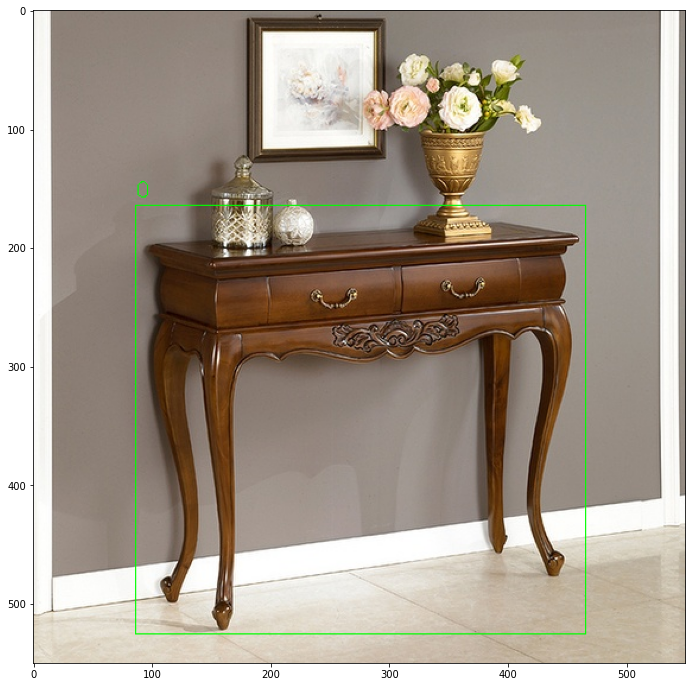

In [10]:
import matplotlib.pyplot as plt
import cv2

temp_path=get_png_from_xml(train_xml_path[0])
img_rgb=cv2.cvtColor(cv2.imread(temp_path), cv2.COLOR_BGR2RGB)

bbox_names, bboxes=get_bboxes_from_xml(train_xml_path[0])

for box_name, box in zip(bbox_names, bboxes):
    cv2.rectangle(img_rgb, (box[0], box[1]), (box[2], box[3]), color=(0,255,0), thickness=1)
    cv2.putText(img_rgb, box_name, (int(box[0]), int(box[1]-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)

In [11]:
import os
ANNO_DIR=train_xml_dir
file_list=os.listdir(ANNO_DIR)
xml_files=sorted([file for file in file_list if file.endswith('.xml')])
#print('xml file list : ', xml_files)
print('xml file 개수 : ', len(xml_files))

xml file 개수 :  3123


개별 XML 정보와 이미지를 tf.train.Example로 변경하는 함수 생성

In [12]:
import xml.etree.ElementTree as ET

#xml을 파싱해서 image와 object의 메타정보를 dict로 반환하는 함수
def get_anno_dict_from_xml(xml_filepath):
    tree=ET.parse(xml_filepath)
    root=tree.getroot()
    bbox_names=[]
    objects=[]

    filename=root.find('filename').text
    size=root.find('size')
    width=int(size.find('width').text)
    height=int(size.find('height').text)

    #파일내에 있는 모든 object Element를 찾음
    for obj in root.findall('object'):
        name=obj.find('name').text
        #pose='Unspecified'
        #truncated, poses, difficult_obj는 사용되지 않지만 create_pascal_voc.py파일과의 호환성을 유지하기 위해 설정
        #truncated=0
        #difficult=0
        occluded=0 #해당 태그는 xml파일에 없기 때문에 디폴트로 0을 넣기

        pose=obj.find('pose').text
        truncated=int(obj.find('truncated').text)
        difficult=int(obj.find('difficult').text)
        #occluded=int(obj.find('occluded').text)

        xmlbox=obj.find('bndbox')
        #위치 좌표가 소수점까지 표시됨
        #pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 반환
        xmin=math.ceil(float(xmlbox.find('xmin').text))
        ymin=math.ceil(float(xmlbox.find('ymin').text))
        xmax=math.ceil(float(xmlbox.find('xmax').text))
        ymax=math.ceil(float(xmlbox.find('ymax').text))
        bbox={
            'xmin':xmin,
            'ymin':ymin,
            'xmax':xmax,
            'ymax':ymax
        }
        single_obj={
            'name':name, 'pose':pose, 'truncated':truncated,
            'difficult':difficult,'occluded':occluded,'bndbox':bbox
            }
        objects.append(single_obj)
    
    anno_dict={
        'folder':'training_data', 'filename':filename,
        'width':width, 'height':height,'object':objects
        }#이미지에 대한 object정보
    return anno_dict

In [13]:
anno_dict=get_anno_dict_from_xml(train_xml_path[0])
anno_dict

{'folder': 'training_data',
 'filename': '100356.png',
 'width': 550,
 'height': 550,
 'object': [{'name': '0',
   'pose': 'Unspecified',
   'truncated': 0,
   'difficult': 0,
   'occluded': 0,
   'bndbox': {'xmin': 86, 'ymin': 164, 'xmax': 465, 'ymax': 525}}]}

In [14]:
# image와 object의 고유 id 부여. 
class Unique_Id(object):
  
  def __init__(self):
    self.image_id = 0
    self.ann_id = 0

  def get_image_id(self):
    self.image_id += 1
    return self.image_id

  def get_ann_id(self):
    self.ann_id += 1
    return self.ann_id

In [15]:
# https://github.com/google/automl/blob/master/efficientdet/dataset/create_pascal_tfrecord.py 참조

import hashlib
import io
import json
import os
import PIL.Image
import tensorflow as tf
from dataset import tfrecord_util

#1개의 image파일 path와 1개의 annotation XML 정보를 가지는 data dic를 이용하여 tf.train.Example를 생성
def dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None, debug=True):
    
    #data는 1개의 xml파일을 dictionary로 변환 anno_dict
    #image는 1개의 xml에 매핑되는 image파일의 절대 경로
    #unique_id는 고유한 image와 object id를 만들기 위한 Unique_Id객체

    #PNG image를 binary 그대로 읽음
    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_png=fid.read()

    #image가 PNG 타입인지 확인
    encoded_png_io=io.BytesIO(encoded_png)
    image=PIL.Image.open(encoded_png_io)
    if image.format != 'PNG':
        raise ValueError('Image format not PNG')

    #image의 고유 key값 생성.
    key=hashlib.sha256(encoded_png).hexdigest()

    #고유한 image id 생성
    image_id=unique_id.get_image_id()
    #image의 width와 height가져옴
    width=data['width']
    height=data['height']

    xmins, ymins, xmaxes, ymaxes=[],[],[],[]
    areas, classes, classes_texts=[],[],[]
    truncated, poses, difficult_obj=[],[],[]
    #만일 annotation에 1개 이상의 object가 있다면,
    if 'object' in data:
        #data(anno_dict)의 'object' key값으로 개별 object 별 annotation정보를 dict로 가지는 list로 구정.
        #이 list를 iteration 수행
        for obj in data['object']:
            difficult=bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            #object 명이 '1','2','3'이 아니면 제외
            if obj['name'] not in label_map_dict:
                continue

            difficult_obj.append(int(difficult))
            #개별 좌표 값을 이미지의 크기로 정규화 하고 list로 저장
            xmins.append(float(obj['bndbox']['xmin'])/width)
            ymins.append(float(obj['bndbox']['ymin'])/height)
            xmaxes.append(float(obj['bndbox']['xmax'])/width)
            ymaxes.append(float(obj['bndbox']['ymax'])/height)
            areas.append((xmaxes[-1] - xmins[-1])*(ymaxes[-1] - ymins[-1]))
            #class 명과 class_id를 list로 저장
            classes_texts.append(obj['name'].encode('utf8'))
            classes.append(label_map_dict[obj['name']]) #encode추가 -> 8.9xml파일 수정하며 삭제
            #truncated, poses, difficult_obj는 사용되지 않지만
            #create_pascel_voc.py파일과의 호환성을 유지하기 위해 저장.
            truncated.append(int(obj['truncated']))
            poses.append(obj['pose'].encode('utf8'))
            difficult_obj.append(obj['difficult'])

        example_dict={
            'height':height, 'width':width, 'filename':data['filename'].encode('utf8'),
            'source_id':str(image_id).encode('utf8'), 'key_sha256':key.encode('utf8'),
            'encoded':encoded_png, 'format':'png'.encode('utf8'),
            'xmin':xmins, 'xmax':xmaxes, 'ymin':ymins, 'ymax':ymaxes,
            'area':areas, 'class_text':classes_texts,'class_label':classes,
            'difficult':difficult_obj, 'truncated':truncated, 'poses':poses
            }

        if debug:
            print('example_dict : ', example_dict)
    example=make_tfrecord_example(example_dict)

    return example


In [16]:
import tensorflow as tf
from dataset import tfrecord_util

#인자로 들어온 dict에 따라 tf.train.Example 을 생성
def make_tfrecord_example(example_dict):
    example=tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': tfrecord_util.int64_feature(example_dict['height']),
                'image/width': tfrecord_util.int64_feature(example_dict['width']),
                'image/filename': tfrecord_util.bytes_feature(example_dict['filename']),
                'image/source_id': tfrecord_util.bytes_feature(example_dict['source_id']),
                'image/key/sha256': tfrecord_util.bytes_feature(example_dict['key_sha256']),
                'image/encoded': tfrecord_util.bytes_feature(example_dict['encoded']),
                'image/format': tfrecord_util.bytes_feature('png'.encode('utf8')),
                'image/object/bbox/xmin': tfrecord_util.float_list_feature(example_dict['xmin']),
                'image/object/bbox/xmax': tfrecord_util.float_list_feature(example_dict['xmax']),
                'image/object/bbox/ymin': tfrecord_util.float_list_feature(example_dict['ymin']),
                'image/object/bbox/ymax': tfrecord_util.float_list_feature(example_dict['ymax']),
                'image/object/area': tfrecord_util.float_list_feature(example_dict['area']),
                'image/object/class/text': tfrecord_util.bytes_list_feature(example_dict['class_text']),
                'image/object/class/label': tfrecord_util.int64_list_feature(example_dict['class_label']), #int64에서 bytes로 변경->8.9xml파일 수정하며 다시 nt64
                'image/object/difficult': tfrecord_util.int64_list_feature(example_dict['difficult']),
                'image/object/truncated': tfrecord_util.int64_list_feature(example_dict['truncated']),
                'image/object/view': tfrecord_util.bytes_list_feature(example_dict['poses'])
            }
        )
    )
    return example

In [17]:
label_map_dict={
    '0':0,
    '1':1,
    '2':2
}

#테스트 용도로 한 개의 Example 생성해 보기
unique_id=Unique_Id()
data=get_anno_dict_from_xml(train_xml_path[0])
print('##xml 파일을 data dic로 변경 결과 : ',data)
image_path=get_png_from_xml(train_xml_path[0])

example=dict_to_tf_example(data, image_path, label_map_dict, unique_id, ignore_difficult_instances=False, ann_json_dict=None)

##xml 파일을 data dic로 변경 결과 :  {'folder': 'training_data', 'filename': '100356.png', 'width': 550, 'height': 550, 'object': [{'name': '0', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'bndbox': {'xmin': 86, 'ymin': 164, 'xmax': 465, 'ymax': 525}}]}
example_dict :  {'height': 550, 'width': 550, 'filename': b'100356.png', 'source_id': b'1', 'key_sha256': b'7120674117562e6d01d227af4b088d4e51ad539a4177668bfdc709a1a786f4dc', 'encoded': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02&\x00\x00\x02&\x08\x02\x00\x00\x00\xe8\xac\xd6\x11\x00\x01\x00\x00IDATx\x9c\x8c\xfdi\xd0-Kr\x18\x86efUw\x9fs\xbe\xfd~w}wy\xeb\xbc7\xf3f\xc7\xcc\x003\xd89 \x00\x12$@\x12\x04\xcc \tJr\xd0A\x8aAy\t[\xa6~\xd8\x7fh9,Z\x0c\xc9\xa6B\x16\x83\x82\x15d\x90\x16!\x87\x05\x9a\x067\x01\xc46 \x16\xce\xbe\xbdy\xf3\xf6\xe5\xbe\xbb\xdf\xfb\xedg\xeb\xee\xaaL\xff\xc8\xee:\xd9\xdd\xe7>\xb0\xe7\xcd\x8d\xfe\xfatWee\xe5^YYx\xef\xee\xed,\xcbF\xa3\x1c\x11\x89\x88\x99\x11\x91\x99#C\x9e\xe7"BD\\\x95\xa3\x8d\x8d\xd7_

In [18]:
example

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\002&\000\000\002&\010\002\000\000\000\350\254\326\021\000\001\000\000IDATx\234\214\375i\320-Kr\030\206efUw\237s\276\375~w}wy\353\2747\363f\307\314\0003\3309 \000\022$@\022\004\314 \tJr\320A\212Ay\t[\246~\330\177h9,Z\014\311\246B\026\203\202\025d\220\026!\207\005\232\0067\001\3046 \026\316\276\275y\363\366\345\276\273\337\373\355g\353\356\252L\377\310\356:\331\335\347>\260\347\315\215\376\372tWee\345^YYx\357\356\355,\313F\243\034\021\211\210\231\021\221\231#C\236\347\"BD\\\225\243\215\215\327_z\351\227\376\207\377~kR0G}SD\020QDD\004\000\000\000\021\001\200\232\277\000\021c\214D\004\000\372\016\"2B\323,\263~\356\234\2131\352}\356|\2141\306\230e\231~R\327u\323,\221s\016\000\"\210\366\256\r\352\257\275?\365I\0170{\243\277b{)0\251\035\205\231\231\201\020\000PV\2378X!*\302\252}A\020\021\207\304\314\372\253\203\006\030m\037\332KG\252\375\022b\214Q\021\242/

학습과 검증용 TFRecord 파일들을 생성
- 학습과 검증용 DataFrame으로 학습, 검증 데이터세트 분류
- 개별 Example을 생성하는 dict_to_tf_example()을 이용하여 모든 데이터 세트를 TFRecord로 생성

In [19]:
file_id_list=sorted([xml_file[:xml_file.rfind('.xml')] for xml_file in os.listdir(train_xml_dir) \
    if '.xml' in xml_file])
#print(file_id_list)
len(file_id_list)

3123

In [20]:
"""
import pandas as pd

pd.set_option('display.max_colwidth', 300)
data_df=pd.DataFrame({'file_id':file_id_list})
#dir이후에 바로 file_id를 해서 png와 xml이 순서차이가 없도록 하는 듯?
data_df['image_path']=train_png_dir+"/"+data_df['file_id']+'.png'
data_df['xml_path']=train_xml_dir+"/"+data_df['file_id']+'.xml'

print(data_df.shape)
data_df.head()
"""

'\nimport pandas as pd\n\npd.set_option(\'display.max_colwidth\', 300)\ndata_df=pd.DataFrame({\'file_id\':file_id_list})\n#dir이후에 바로 file_id를 해서 png와 xml이 순서차이가 없도록 하는 듯?\ndata_df[\'image_path\']=train_png_dir+"/"+data_df[\'file_id\']+\'.png\'\ndata_df[\'xml_path\']=train_xml_dir+"/"+data_df[\'file_id\']+\'.xml\'\n\nprint(data_df.shape)\ndata_df.head()\n'

In [21]:
#원래 코드에서는 이 부분에서 train과 test를 나누지만
#이미 EfficientDet_split.ipynb에서 나눴음

In [22]:
#하지만 예제에서는 dataframe을 사용했기 때문에 동일하게 하기 위해 df생성
import pandas as pd

pd.set_option('display.max_colwidth', 300)
train_df=pd.DataFrame({'file_id':file_id_list}) #이전전 셀에서 train_xml_dir를 사용해서  그대로 사용
train_df['image_path']=train_png_dir+"/"+train_df['file_id']+'.png'
train_df['xml_path']=train_xml_dir+"/"+train_df['file_id']+'.xml'

print(train_df.shape)

(3123, 3)


In [23]:
train_df.head()

,file_id,image_path,xml_path
0,100356,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/100356.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/100356.xml
1,100357,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/100357.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/100357.xml
2,102460,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/102460.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/102460.xml
3,102461,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/102461.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/102461.xml
4,102463,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/PngImages/102463.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/train/XmlFiles/102463.xml


In [24]:
file_id_list=sorted([xml_file[:xml_file.rfind('.xml')] for xml_file in os.listdir(test_xml_dir) \
    if '.xml' in xml_file])
#print(file_id_list)
len(file_id_list)

pd.set_option('display.max_colwidth', 300)
test_df=pd.DataFrame({'file_id':file_id_list})
test_df['image_path']=test_png_dir+"/"+test_df['file_id']+'.png'
test_df['xml_path']=test_xml_dir+"/"+test_df['file_id']+'.xml'

print(test_df.shape)

(761, 3)


In [25]:
test_df.head()

,file_id,image_path,xml_path
0,102458,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/PngImages/102458.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/102458.xml
1,102460,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/PngImages/102460.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/102460.xml
2,102471,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/PngImages/102471.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/102471.xml
3,102477,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/PngImages/102477.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/102477.xml
4,103933,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/PngImages/103933.png,/mnt/sda1/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/103933.xml


In [26]:
#모든 image/xml파일들을 TFRecord로 생성
def make_tfrecords(meta_df, output_dir, output_prefix, num_shards):
    xml_list=meta_df['xml_path'].to_list()
    image_list=meta_df['image_path'].to_list()

    unique_id=Unique_Id()
    #num_shards만큼의 TFRecordWriter 객체 생성
    writers=[
        tf.io.TFRecordWriter(output_dir+output_prefix+'-%05d-of-%05d.tfrecord' % 
                            (i, num_shards))
        for i in range(num_shards)
    ]
    #xml 개수만큼 iteration을 돌려서 Example을 만들고
    #개별 Example을 특정 shard에 해당하는 TFRecord에 append
    for idx, xml_path in enumerate(xml_list):
        if idx%100==0:
            print('On image ',idx,' of ',len(xml_list))

        data=get_anno_dict_from_xml(xml_path)
        image_path=image_list[idx]
        #개별 Example 생성
        tf_example=dict_to_tf_example(data, image_path, label_map_dict, unique_id,
                                    ignore_difficult_instances=False, ann_json_dict=None,
                                    debug=False)
        #num_shard 만큼 만들어진 TFRecord에 Example을 iteration을 수행하면서 해당하는 TFRecord로 append
        writers[idx%num_shards].write(tf_example.SerializeToString())

    #num_shards만큼 만들어진 TFRecordWriter 객체 close
    for writer in writers:
        writer.close()

In [ ]:
#!mkdir -p ./tfrecord/train
#!mkdir -p ./tfrecord/test
#tfrecord파일을 만들어 저장할 디렉토리 생성

In [ ]:
print('#### train용 tfrecords 생성 시작 ####')
make_tfrecords(train_df, './tfrecord/train/','train',num_shards=100)

In [ ]:
print('#### val용 tfrecords 생성 시작 ####')
make_tfrecords(test_df, './tfrecord/test/','test',num_shards=100)

In [ ]:
#FileNotFoundError: [Errno 2] No such file or directory: '/home/plass-heesu/KimHeeSu/munsu/Hanssem/Data/test/XmlFiles/100356.xml'
#근데 100356.xml은 train에 들어가 있는건데..왜ㅠㅠㅠ
#이름 부분엔 data_df를 그대로 써서 그렇게 된것이었음

Pretrained 모델을 다운로드 받고 Train을 위한 config 생성
- pretrained 모델은 efficientdet-d2
- num_classes는 2, max_instances_per_image는 기본 100개. 1개의 이미지에 특정 object의 갯수가 100개를 초과하는 경우가 있음. max_instances_per_image=200 으로 수정

- 강의에서는 이렇게 나왔는데 가구 검색에서 사진 1개에 100개가 넘어가나? 싶어서...
- 우선 num_classes=3, max_instances_per_image는 기본인 100개로 설정

In [27]:
#epochs 시마다 학습된 weight 파일을 저장한 디렉토리 Google drive로 설정
#Google Drive 접근을 위한 Mount 적용
#이지만 weight저장할 디렉토리는 /Hanssem/EfficientDet_Weight파일

import os, sys

model_weight=os.path.join(os.getcwd(),'EfficientDet_Weight')
print(model_weight)

/mnt/sda1/KimHeeSu/munsu/Hanssem/EfficientDet_Weight


In [28]:
!mkdir ./EfficientDet_Weight/efficientdet-d2

mkdir: cannot create directory ‘./EfficientDet_Weight/efficientdet-d2’: File exists


In [29]:
MODEL='efficientdet-d2'

def download(m):
    if m not in os.listdir(model_weight):
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
        !tar zxf {m}.tar.gz
    ckpt_path=os.path.join(model_weight, m)
    return ckpt_path

#Download checkpoint
ckpt_path=download(MODEL)
print('Use model in {}'.format(ckpt_path))
#모델?이 다운받기만 되고 압축 풀기는 안되서 그냥 파일질라로 로컬로 가져와 압출 풀고 model_weight로 설정한 주소 안에 efficientdet-d2파일 만들어서 그 안에 넣어줌

Use model in /mnt/sda1/KimHeeSu/munsu/Hanssem/EfficientDet_Weight/efficientdet-d2


In [30]:
#train_file_pattern, test_file_pattern에 사용하기 위한 주소
train_temp=os.path.join(os.getcwd(),'tfrecord','train')
test_temp=os.path.join(os.getcwd(),'tfrecord','test')
print(train_temp+'/*.tfrecord')

/mnt/sda1/KimHeeSu/munsu/Hanssem/tfrecord/train/*.tfrecord


In [31]:
class TRAIN_CFG:
    model_name='efficientdet-d2'
    strategy=''
    model_dir=model_weight
    pretrained_ckpt = ckpt_path#coco로 pretrained된 checkpoint파일이 있는 디렉토리 위치

    #num_classes=3으로 변경
    hparams='num_classes=3,moving_average_decay=0,mixed_precision=true'
    use_xla=False
    use_fake_data=False

    #max_instances_per_image를 200으로 설정하고
    #d2모델이 상대적으로 더 크기 때문에 batch_size를 8로 설정시 GPU Out of Memory발생
    batch_size=4
    eval_samples=5000 #evaluation image데이터 갯수
    steps_per_execution=1 #train시 steps 횟수
    num_examples_per_epoch=3000 #1epochs 시 적용하는 examples 개수
    num_epochs=20 #epochs 횟수
    train_file_pattern='./tfrecord/train/train-*.tfrecord'
    test_file_pattern='./tfrecord/test/test-*.tfrecord'
    test_json_file=None #optional coco validation json
    mode='traineval' #train만 적용 또는 train과 eval함께 적용(traineval)
    num_shards=100
    max_instances_per_image=100

    num_cores=2
    tpu=None
    gcp_project=None
    tpu_zone=None
    eval_master=''
    eval_name=None
    tf_random_seed=2021
    profile=False
    debug=False

In [32]:
import tensorflow.compat.v1 as tf

from keras.train import setup_model
import hparams_config

import utils
from keras import tfmot
from keras import train_lib
from keras import util_keras

config=hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch=TRAIN_CFG.num_examples_per_epoch

if tf.config.list_physical_devices('GPU'):
    ds_strategy=tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
    ds_strategy=tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)


params=dict(
    profile=TRAIN_CFG.profile,
    mode=TRAIN_CFG.mode,
    model_name=TRAIN_CFG.model_name,
    steps_per_execution=TRAIN_CFG.steps_per_execution,
    num_epochs=TRAIN_CFG.num_epochs,
    model_dir=TRAIN_CFG.model_dir,
    steps_per_epoch=steps_per_epoch,
    strategy=TRAIN_CFG.strategy,
    batch_size=TRAIN_CFG.batch_size,
    tf_random_seed=TRAIN_CFG.tf_random_seed,
    debug=TRAIN_CFG.debug,
    test_json_file=TRAIN_CFG.test_json_file,
    eval_samples=TRAIN_CFG.eval_samples,
    num_shards=ds_strategy.num_replicas_in_sync,
    max_instances_per_image = TRAIN_CFG.max_instances_per_image
)

config.image_size = '550x550'
config.override(params, True)

#config.image_size=(550,550) #????
#image size를 tuple 형태로 변환. 512는 (512,512)로 '1920x880'은 (1920, 880)으로 변환
config.image_size=utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b2
batch_size: 4
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 5000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 5
fpn_config: null
fpn_name: null
fpn_num_filters: 112
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 550
- 550
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_insta

In [33]:
print(config.image_size)

(550, 550)


In [34]:
import utils
from keras import tfmot
from keras import train_lib
from keras import util_keras
#p100에서는 적용할 필요 없음

'''
precision = utils.get_precision(config.strategy, config.mixed_precision)
policy = tf.keras.mixed_precision.Policy(precision)
tf.keras.mixed_precision.set_global_policy(policy)
'''

'\nprecision = utils.get_precision(config.strategy, config.mixed_precision)\npolicy = tf.keras.mixed_precision.Policy(precision)\ntf.keras.mixed_precision.set_global_policy(policy)\n'

Dataset 과 Model 생성하고 학습 수행
- 앞에서 만든 train과 val용 TFRecord를 이용하여 dataloader.InputReader를 생성하는 함수 생성
- efficientdet-d2모델 생성 후 pretrained모델의 weight전이
- batch_size 4로 설정. 8로 설정시 GPU Memory OOM발생 가능성 높음(Out Of Memory)
- epochs 20으로 학습 수행

In [35]:
import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.test_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader(
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(config.as_dict())

In [36]:
from keras import train_lib
from keras import train

def get_efficientdet_model(config):
    #3개의 class를 가진 efficientdet d2모델을 생성
    model=train_lib.EfficientDetNetTrain(config=config)
    model=train.setup_model(model, config)
    #만약 pretrained 모델이 있으면, 해당 checkpoing weight를 모델로 로딩
    #이때 classification layer는 제외
    #class TRAIN_CFG : pretrained_ckpt='/content/efficientdet-d2
    if TRAIN_CFG.pretrained_ckpt:
        ckpt_path=tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
        #classification layer를 제외하고 pretrained weight를 생성된 모델로 로딩
        util_keras.restore_ckpt(
            model,
            ckpt_path,
            config.moving_average_decay,
            exclude_layers=['class_net']
        )
    train.init_experimental(config)
    return model

model=get_efficientdet_model(config)
model.summary()

/home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      multiple                  7267314   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  39984     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  678479    
_________________________________________________________________
class_net (ClassNet)         multiple                  51771     
_________________________________________________________________
box_net (BoxNet)             multiple                  52788     
Total params: 8,090,336
Trainable params: 8,008,560
Non-trainable params: 81,776
___________________________________________________

In [37]:
print(config.mode)

traineval


In [38]:
!conda list numpy

# packages in environment at /home/plass-heesu/anaconda3/envs/munsutf2.4:
#
# Name                    Version                   Build  Channel
numpy                     1.20.0                   pypi_0    pypi


In [39]:
sys.path.append('./automl/efficientdet')

from keras import train
import numpy as np

config.batch_size=4
train_steps_per_epoch=train_df.shape[0]
test_steps_per_epoch=test_df.shape[0]
print('train_steps_per_epoch : ',train_steps_per_epoch,
    'test_steps_per_epoch : ', test_steps_per_epoch)

test_dataset=get_dataset(False, config) if 'eval' in config.mode else None
model.fit(
    get_dataset(True, config),
    epochs=20,
    steps_per_epoch=train_steps_per_epoch,
    callbacks=train_lib.get_callbacks(config.as_dict(), test_dataset),
    validation_data=test_dataset,
    validation_steps=test_steps_per_epoch
)

tf.keras.backend.clear_session()

train_steps_per_epoch :  3123 test_steps_per_epoch :  761


NotImplementedError: in user code:

    ./automl/efficientdet/dataloader.py:443 None  *
        anchor_labeler, params)
    ./automl/efficientdet/dataloader.py:338 dataset_parser  **
        num_positives) = anchor_labeler.label_anchors(boxes, classes)
    ./automl/efficientdet/keras/anchors.py:238 label_anchors
        anchor_box_list, gt_box_list, gt_labels)
    ./automl/efficientdet/object_detection/target_assigner.py:144 assign
        groundtruth_weights = tf.ones([num_gt_boxes], dtype=tf.float32)
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:3120 ones
        output = _constant_if_small(one, shape, dtype, name)
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2804 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:6 prod
        
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3031 prod
        keepdims=keepdims, initial=initial, where=where)
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:855 __array__
        " a NumPy call, which is not supported".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (parser/strided_slice_16:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [ ]:
# test_dataset=get_dataset(False, config) if 'eval' in config.mode else None 에서 오류 발생
# NotImplementedError: Cannot convert a symbolic Tensor (parser/strided_slice_16:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
# 아래 링크에서는 python 3.8이 아니라 3.6으로 바꿔보라고 함
# https://github.com/tensorflow/models/issues/9706
# python 3.6의 경우 pip install python==3.6으로 해도 설치가 안됨
# 계속 안되면 아예 새로운 가상환경 만드는 것도 고려해볼것
#혹은 몇몇 코드만 가지고 따로 주피터노트북 생성?

학습된 모델 파일을 이용하여 inference 수행

In [41]:
import sys

sys.path.append('./automl/efficientdet')

In [43]:
import hparams_config
import utils

infer_config=hparams_config.get_efficientdet_config('efficientdet-d2')

#config의 특정 학목을 update
infer_config.model_name='efficientdet-d2'
infer_config.model_dir=TRAIN_CFG.model_dir

infer_config.num_classes=3
infer_config.is_training_bn=False
infer_config.nms_configs.score_thresh=0.4
infer_config.image_size='512x512'
infer_config.image_size=utils.parse_image_size(infer_config.image_size)

print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b2
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 5
fpn_config: null
fpn_name: null
fpn_num_filters: 112
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 512
- 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: false
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 

In [47]:
import inference
from keras import efficientdet_keras
import tensorflow as tfrecord

model=efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('### checkpoing name : ', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

/home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


### checkpoing name :  None


AttributeError: 'NoneType' object has no attribute 'endswith'

In [48]:
import time

class ExportModel(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model=model

    @tf.function
    def f(self, imgs):
        #model(imgs, training=False, post_mode='global')
        return self.model(imgs, training=False, post_mode='global')

export_model=ExportModel(model)

In [49]:
labels_to_names={0:'수납장',1:'러그', 2:'침대'}

In [50]:
def get_detected_img(export_model, img_array, is_print=True):
    #automl efficient는 반환 bbox좌표값이 원본 이미지 좌표값으로 되어 있으므로
    #별도의 scaling작업 필요 없음
    #height=img_array.shape[0]
    #width=img_array.shape[1]
    #cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트하므로
    #그림 표현을 위한 별도의 이미지 배열 생성
    draw_img=img_array.copy()

    #bounding box의 테두리와 caption 글자색 지정
    green_color=(0,255,0)
    red_color=(255,0,0)

    #cv2로 만들어진 numpy image array를 tensor로 변환
    img_tensor=tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
    #img_tensor=tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

    #efficientdet 모델을 다운로드 한 뒤 inference 수행
    start_time=time.time()
    #automl efficientdet 모델은 bbox, score, classes, num_detections를 각각 tensor로 반환
    boxes, scores, classes, valid_len=export_model.f(img_tensor)
    #Tensor값을 시각화를 위해 numpy로 변환
    boxes=boxes.numpy()
    scores=scores.numpy()
    classes=classes.numpy()
    valid_len=valid_len.numpy()

    for i in range(valid_len[0]):
        #detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop중단
        score=scores[0,i]
        box=boxes[0,i]

        xmin=box[1]
        ymin=box[0]
        xmax=box[3]
        ymax=box[2]

        #class id 추출하고 class명으로 매핑
        class_id=classes[0,i]
        caption="{}: {:.4f}".format(labels_to_names[class_id].encode('utf8'),score)
        print(caption)
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림
        #위치 인자는 반드시 정수형
        cv2.rectangle(draw_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)),
                    color=green_color, thickness=1)
        cv2.putText(draw_img, caption, (int(xmin), int(ymin-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.2, red_color, 1)
        
        if is_print:
            print('Detection 수행시간 : ', round(time.time()-start_time, 2), "초")

        return draw_img

/home/plass-heesu/anaconda3/envs/munsutf2.4/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


TypeError: Image data of dtype object cannot be converted to float

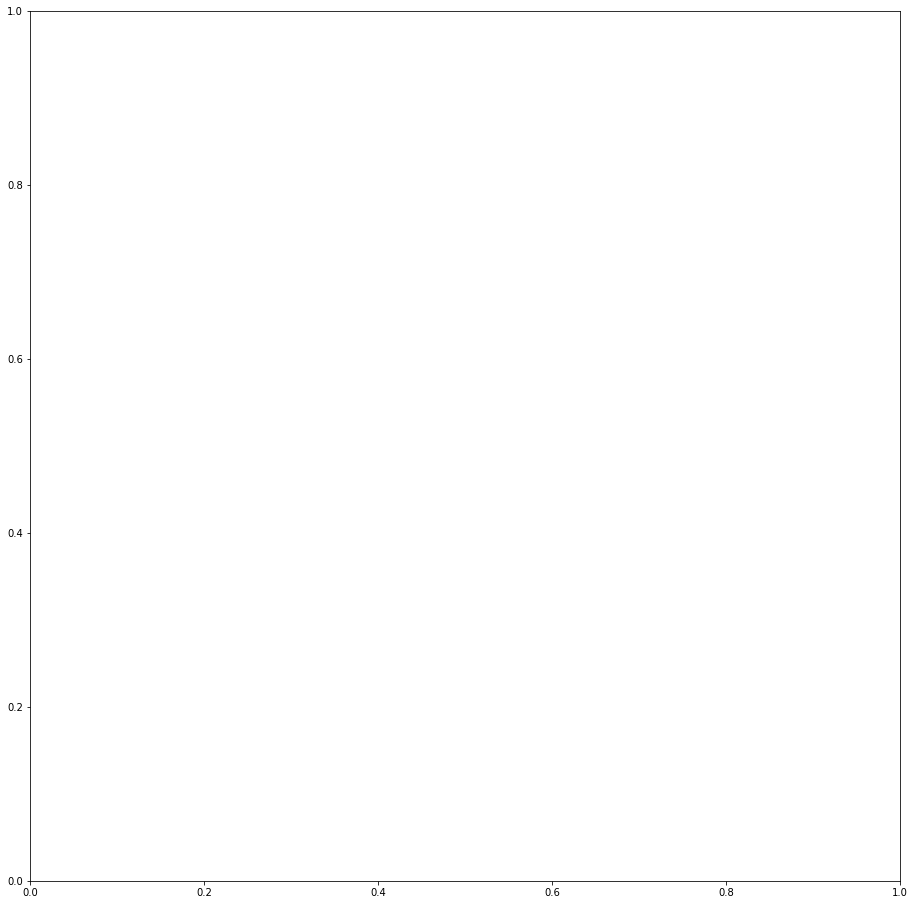

In [53]:
import cv2
import matplotlib.pyplot as plt

img_array=cv2.cvtColor(cv2.imread(test_png_path[0]), cv2.COLOR_BGR2RGB)

draw_img=get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16,16))
plt.imshow(draw_img)